# Result figure 4: TRF, timed contributions to score and spatial extent

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import zscore, ttest_rel
import mne
from pyeeg.models import TRFEstimator
from pyeeg.vizu import topomap
from pyeeg.models import LOGGER
LOGGER.setLevel('WARNING')

from audiobook.utils import extract_story_parts_data
from audiobook.features import get_feature_signal
from audiobook import subjects

import pickle
import os, glob

In [4]:
featsets = [['wordonsets'],
            ['wordonsets', 'depth', 'close'],
            ['wordonsets', 'surprisal', 'entropy'],
            ['wordonsets', 'surprisal', 'entropy', 'depth', 'close']]

colors = {'wordonsets': (0.3,)*3}
for k in featsets:
    key = '_'.join(k)
    is_predict = any([f in key for f in ['surprisal', 'wordfrequency']])
    is_syntax = any([f in key for f in ['open', 'depth', 'close']])
    if is_predict and not is_syntax:
        if 'entropy' in key:
            colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[2]
        else:
            colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[3]
    if is_syntax and not is_predict:
        colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[0]
    if is_syntax and is_predict:
        colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[-1]

In [5]:
import pandas as pd
my_palette = sns.color_palette(list(colors.values()))
from matplotlib_venn import venn3
from scipy.stats import ttest_1samp

In [6]:
import warnings
warnings.filterwarnings('ignore', message='distutils')

In [7]:
paper_fontsizes = {
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 10
}

palette = sns.color_palette(['#127C6F', '#2AAD9D', '#AA43A0', '#7A4B9B', 'orange'])
palette = sns.color_palette([ '#2AAD9D', '#7A4B9B', 'orange'])

##  Params and book-keeping

In [8]:
fs = 50
use_ica=True
freqbands = {'delta': [0.5,4.5],
            'theta': [4.,8.],
            'alpha': [8.,12.],
            'beta': [16,25],
            'gamma': [30.,60.],}

fband = freqbands['delta']
X = get_feature_signal(feats=featsets[-1], srate=fs)

Load stimulus features
Loading feature signal for : ['wordonsets', 'surprisal', 'entropy', 'depth', 'close']
Done. X shape: (14900, 5)


## Score timed-TRF (Panel C/D ...)

In [11]:
use_ica = True
bandname = 'beta'
itc = False
pac = False
is_poster = False

Found 27 files.


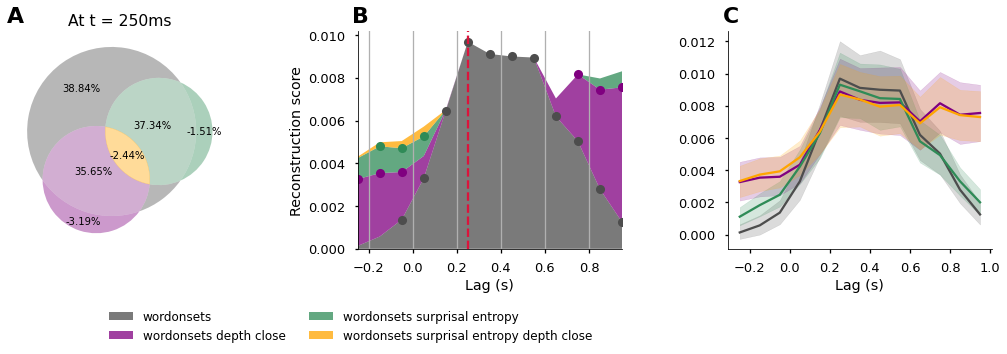

In [42]:
files = [f for f in glob.glob('Data/Timed*') if (bandname in f)]
def selector(f):
    if pac: return 'pac' in f
    if use_ica and itc: return ('ica' in f) and ('itc' in f) and ('pac' not in f)
    if use_ica and not itc: return ('ica' in f) and ('itc' not in f) and ('pac' not in f)
    if not use_ica and itc: return ('ica' not in f) and ('itc' in f) and ('pac' not in f)
    if not use_ica and not itc: return ('ica' not in f) and ('itc' not in f) and ('pac' not in f)
files = list(filter(selector, files))
print(f"Found {len(files)} files.")

# cur_file = np.random.choice(files)

################# Readin in data ################

all_dfs = []
for cur_file in files:
    idx_sub = cur_file.find('sub-')
    subj = cur_file[idx_sub:idx_sub+7]
    if subj=='sub-002': continue # remove sub002
    with open(cur_file, 'rb') as f:
        timed_score = pickle.load(f)

    df = pd.DataFrame(timed_score)
    df.index.set_names('lags', inplace=True)
    df = df.reset_index().melt(id_vars='lags', var_name='features', value_name='score')
    df['subject'] = subj
    all_dfs.append(df)
    
df = pd.concat(all_dfs)

################ Arranging and formatting data ###########################

if itc or pac: df.score = df.score.abs()

avg_df = df.groupby(['lags', 'features']).mean().reset_index()
data = avg_df.pivot(index='lags', columns='features', values='score').to_numpy().T
wo = data[0]

#data[-1] -= (data[1] + data[2])/2
data[1:] -= wo
data[-1] -= np.maximum(data[1],data[2])

wo, synt, stats, all_feats = data

wo_data = df[df.features=='wordonsets'].pivot(index=['lags'], columns='subject', values='score').to_numpy()
stats_data = df[df.features=='wordonsets_surprisal_entropy'].pivot(index=['lags'], columns='subject', values='score').to_numpy()
synt_data = df[df.features=='wordonsets_depth_close'].pivot(index=['lags'], columns='subject', values='score').to_numpy()
all_data = df[df.features=='wordonsets_surprisal_entropy_depth_close'].pivot(index=['lags'], columns='subject', values='score').to_numpy()


################ PLOTTING ################################

alpha_crit = 0.05/8/3 # divided by number of lags (bonfernni)

with plt.style.context(['seaborn-poster' if is_poster else 'seaborn-talk', {'figure.facecolor':'w', 'axes.prop_cycle':plt.cycler(color=my_palette), 'pdf.fonttype':42}]):
    f, ax = plt.subplots(1, 3, figsize=(18, 4), gridspec_kw={'wspace':0.4})
    best_lag = np.argmax(all_feats)
    best_lag = np.searchsorted(df.lags.unique(), 0.25)
    venn_data = np.asarray([wo[best_lag], stats[best_lag], wo[best_lag] + stats[best_lag], synt[best_lag], synt[best_lag] + wo[best_lag], synt[best_lag] + stats[best_lag], all_feats[best_lag]])
    venn_data /= sum(venn_data)
    v = venn3(venn_data, normalize_to=1, subset_label_formatter=lambda s: f'{s:.2%}', ax=ax[0],
              set_colors=(colors['wordonsets'], colors['wordonsets_surprisal_entropy'], colors['wordonsets_depth_close']), set_labels=('','',''))
    v.get_patch_by_id('111').set_color(colors['wordonsets_surprisal_entropy_depth_close'])
    if is_poster:
        v.get_label_by_id('100').set_fontsize(13)
        v.get_label_by_id('101').set_fontsize(13)
        v.get_label_by_id('110').set_fontsize(13)
        v.get_label_by_id('001').set_fontsize(13)
        v.get_label_by_id('010').set_fontsize(13)
        v.get_label_by_id('111').set_fontsize(13)
    
    ax[0].set_title(f'At t = {df.lags.unique()[best_lag]*1e3:.0f}ms')
    
    #p = ax[1].stackplot(df.lags.unique(), data, alpha=0.8)
    p = ax[1].stackplot(df.lags.unique(), np.where(data>0.0, data, 0.0), alpha=0.75)
    ax[1].plot(df.lags.unique(),  np.where(ttest_1samp(wo_data, popmean=0, axis=1).pvalue > alpha_crit, np.nan, wo), ls='', marker='o')
    teststats = ttest_1samp(synt_data - wo_data, popmean=0, axis=1) # stats for synt
    ax[1].plot(df.lags.unique(), np.where((teststats.pvalue <= alpha_crit) & (teststats.statistic>0), wo+synt, np.nan), ls='', marker='o')
    teststats = ttest_1samp(stats_data - wo_data, popmean=0, axis=1) # stats for stat
    ax[1].plot(df.lags.unique(), np.where((teststats.pvalue <= alpha_crit) & (teststats.statistic>0), wo+stats+synt, np.nan), ls='', marker='o')
    teststats = ttest_1samp(all_data - np.maximum(synt_data, stats_data), popmean=0, axis=1) # stats for all
    ax[1].plot(df.lags.unique(), np.where((teststats.pvalue <= alpha_crit) & (teststats.statistic>0), wo+stats+synt+all_feats, np.nan), ls='', marker='o')
    ax[1].grid('major', axis='x')
    ax[1].set_xmargin(0)
    ax[1].axvline(df.lags.unique()[best_lag], c='crimson', ls='--')
    
    sns.lineplot(data=df, y='score', x='lags', hue='features', ax=ax[2], legend=False)
    
    sns.despine(ax=ax[1])
    sns.despine(ax=ax[2])
    ax[1].set_xlabel('Lag (s)')
    ax[2].set_xlabel('Lag (s)')
    ax[1].set_ylabel('Reconstruction score')
    ax[2].set_ylabel('')
    ax[1].legend(p, [f.replace('_', ' ') for f in avg_df.features.unique()],
                 bbox_to_anchor=(0.6, -0.05),
                 bbox_transform=f.transFigure, ncol=2, frameon=False, fontsize=12 if not is_poster else 14)
    
    #Add labels to panels:
    for a, letter in zip(ax, 'ABC'):
        a.annotate(letter, xy=(-0.02, 1.04), xycoords='axes fraction', fontweight='bold', fontsize=22) # fontsize=14 for paper
    
    if not is_poster:
        f.savefig(f'Results/Timed_Scoring_relative_contributions_{bandname}{"ITC" if itc else ""}{"PAC" if pac else ""}_ica-{use_ica}.pdf', bbox_inches='tight')
    else:
        f.savefig(f'Results/Timed_Scoring_relative_contributions_{bandname}{"ITC" if itc else ""}{"PAC" if pac else ""}_ica-{use_ica}_poster.pdf', bbox_inches='tight')

### Plotting of spatial projections happens here

In [114]:
from audiobook.utils import read_hdf_raws, STORIES, DATA_PATH
from audiobook.source_space import get_lcmv_filters
from sigevd import TRFBasedSpatialProjection
from scipy.signal import hilbert
from TRF_sanity import get_source_image_in_ax

In [84]:
def project_scores(trf, proj, x, y):
    """
    Here I spatially project to score a sensor TRF into another (components or source) space.
    
    Proj can be any spatial filters, e.g. LCMV for source space reconstruction could work.
    """
    y = proj.transform(y)
    yh = proj.transform(trf.predict(x))
    return np.diag(np.corrcoef(y, yh, rowvar=False), k=proj.n_components)

def normalize_complex(x):
    return x/np.abs(x)

In [184]:
# Loading data
subject = 'sub-018'

In [185]:
band = 'theta'
proj_band = 'theta' # interesting things happen when beta is projected on delta'projectors
compute_itc = False
compute_PAC = False
band_amp = 'beta'
band_phase = band
trf = TRFEstimator.load(f'/project/3027007.01/analysis/Hugo/Data/TRF/sensor/{proj_band}/{subject}_xval_TRFwordonsets_surprisal_entropy_depth_close.npz')

fs = trf.srate
if compute_itc or compute_PAC:
    print(f'Computing {("ITPC" if (compute_itc and not compute_PAC) else "PAC")}')
else:
    print(f'Computing {("Power" if (freqbands[band][0] > 7.0) else "low-frequency activity")}')
Y = []
for k in range(9):
    r_phase = read_hdf_raws(subject, story=STORIES.filename.str.strip('.wav')[k], fband=band_phase if compute_PAC else band)
    if compute_itc or compute_PAC:
        r_phase = normalize_complex(hilbert(r_phase))
    
    r_amp = read_hdf_raws(subject, story=STORIES.filename.str.strip('.wav')[k], fband=band_amp if compute_PAC else band)

    y = (r_phase if freqbands[band_phase][0] < 7.0 else 1.0) * (1. if ((compute_itc and not compute_PAC) or freqbands[band][0] < 7.0) else r_amp)
    #y = r_amp
    Y.append(y.T)

info = mne.io.read_info(f'/project/3027007.01/processed/{subject}/meg/audioBook-filtered-ICAed-raw.fif')
info = mne.pick_info(info, sel=mne.pick_types(info, meg=True, ref_meg=False, exclude=['MLT41', 'MRO52']))

Computing low-frequency activity
    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.


In [186]:
proj = TRFBasedSpatialProjection(trf, n_components=6)
proj.fit(x=np.vstack(X[:9]), y=np.vstack(Y[:9]));

25.97% of variance explained with 6 components.


In [187]:
proj_scores = {}
story_loop = tqdm(range(9), leave=False)
for kf, feats in enumerate(featsets):
    X = get_feature_signal(srate=50, feats=feats, verbose=False)
    lengths = [min(len(r), len(x)) for x,r in zip(X, Y)]
    if not compute_PAC:
        trf = TRFEstimator.load(f'/project/3027007.01/analysis/Hugo/Data/TRF/sensor/{proj_band}/{subject}_xval_TRF{"_".join(feats)}.npz')
    else:
        trf = TRFEstimator(srate=50, tmin=-0.2, tmax=0.7, alpha=[0.])
        trf.fit([x[:l] for x,l in zip(X, lengths)], [y[:l] for y,l in zip(Y, lengths)]);
    proj_scores["_".join(feats)] = []
    story_loop.reset()
    for k in range(9):
        story_loop.desc = f'Featset {kf+1}/{len(featsets)} '
        story_loop.update()
        story_loop.refresh()
        l = min(len(X[k]), len(Y[k]))
        proj_scores["_".join(feats)].append(
#             project_scores(trf, proj, X[k][:l], raws[k]._data.T[:l])
            project_scores(trf, proj, X[k][:l], Y[k][:l])
        )
story_loop.close()

if compute_PAC:
    # use abs only for complex scores
    for f, score_list in proj_scores.items():
        for k, score in enumerate(score_list):
            proj_scores[f][k] = abs(score)

  0%|          | 0/9 [00:00<?, ?it/s]

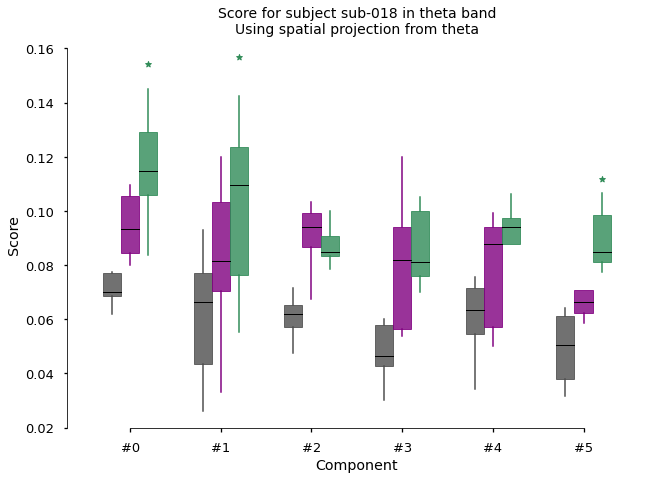

In [188]:
ncomp = proj.n_components

with plt.style.context(['seaborn-talk', {'figure.facecolor':'w', 'axes.prop_cycle':plt.cycler(color=my_palette),
                                         'pdf.fonttype':42}]):
    for k, fea in enumerate(featsets[:-1]):
        c = colors['_'.join(fea)]
        plt.boxplot(np.asarray(proj_scores['_'.join(fea)]).squeeze(),
                    positions=np.arange(ncomp)+(k-1)*0.2, widths=0.2,
                    patch_artist=True, boxprops=dict(facecolor=c, edgecolor=c, alpha=0.8),
                    medianprops=dict(color='k', lw=1., zorder=5), showcaps=False, showfliers=False,
                    whiskerprops=dict(color=c, lw=1.5));
# Stats:
stats = ttest_rel(np.asarray(proj_scores['wordonsets_surprisal_entropy']).squeeze(),
          np.asarray(proj_scores['wordonsets_depth_close']).squeeze())
loc = np.where(stats.pvalue < 0.051)
if len(loc[0]) > 0:
    for l in loc[0]:
        key = 'wordonsets_surprisal_entropy' if stats.statistic[l]>0 else 'wordonsets_depth_close'
        vals = np.asarray(proj_scores[key]).squeeze()[:, l]
        plt.scatter(l + 0.2*float(stats.statistic[l]>0), vals.max(0)+0.5*np.std(vals, axis=0), color=colors[key], marker='*')
plt.xticks(np.arange(ncomp), [f'#{k}' for k in range(ncomp)]);
plt.xlabel('Component')
plt.ylabel('Score')
plt.title(f"""Score for subject {subject} in {band} band
Using spatial projection from {proj_band}""", fontdict={'fontsize':14})
sns.despine(trim=True)

Text(0.5, 1.08, 'Components activation maps')

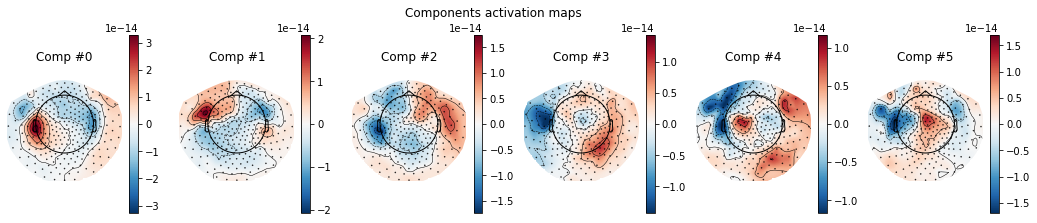

In [189]:
f, ax = plt.subplots(1, proj.n_components, figsize=(18, 3))
pass_through = np.abs if compute_PAC else lambda x: x
for k in range(proj.n_components):
    topomap(pass_through(proj.v_[:, k] @  proj.cov_), info=info, ax=ax[k])
    ax[k].set_title(f'Comp #{k}')
plt.suptitle('Components activation maps', y=1.08)    

In [190]:
fwd = mne.read_forward_solution(os.path.join(DATA_PATH, 'processed', subject, 'meg', 'oct6-fwd.fif'))
inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov=mne.cov.read_cov(os.path.join(DATA_PATH, 'processed', subject, 'meg', 'noise-cov.fif')),
                                             # fixed=True)
                                             loose=1)
morph_file = f'/project/3027007.01/processed/{subject}/meg/{subject}-morph.h5'
morph = mne.morph.read_source_morph(morph_file)

Reading forward solution from /project/3027007.01/processed/sub-018/meg/oct6-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (6146 sources, 269 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    263 x 263 full covariance (kind = 1) found.
Computing inverse operator with 261 channels.
    261 out of 269 channels remain after picking
Selected 261 channels
Creating the depth weighting matrix...
    261 magnetometer or axial gradiometer channels
    limit = 6147/6146 = 4.440978
    scale = 2.61469e-10 exp = 0.8
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 2.1e-13 (2.2e-16 eps * 261 dim * 3.6  max singular value)
    Estimated rank (mag): 261
    MAG: rank 261 computed from 261 data channels with 0 projectors
    Setting small MAG eigen

In [156]:
cov = mne.cov.Covariance(proj.cov_, info.ch_names, [], [], 267)

In [199]:
cov = np.sum([np.real(y - y.mean(0)).T@np.real(y - y.mean(0)) for y in Y], 0)
cov = mne.cov.Covariance(cov, info.ch_names, [], [], 267)

In [196]:
cov = mne.read_cov(os.path.join(DATA_PATH, 'processed', subject, 'meg', 'story-cov.fif'), verbose=False) # ... this has 259 channels for sub-004 for example ...-_-    
cov = cov.pick_channels(info.ch_names)

In [200]:
lcmv = get_lcmv_filters(subject, cov, verbose=False)

    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Computing beamformer filters...


In [166]:
datadir = os.path.join(DATA_PATH, 'processed')
my_sqmap = sns.blend_palette(['black' , 'darkred', 'coral', 'yellow'], as_cmap=True)
my_map = sns.blend_palette(['cyan', 'deepskyblue', 'darkblue' , 'black' , 'darkred', 'coral', 'yellow'], as_cmap=True)

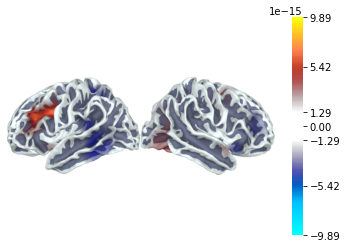

In [206]:
k = 5
# source_map = mne.minimum_norm.apply_inverse(mne.EvokedArray(pass_through(proj.v_[:, k] @  proj.cov_)[:, None], info), inv, 0.2)
# or
source_map = mne.beamformer.apply_lcmv(mne.EvokedArray(pass_through(proj.v_[:, k] @  proj.cov_)[:, None], info), lcmv)
# source_map.data = np.abs(source_map.data)

source_map = morph.apply(source_map)

f = plt.figure()
ax = f.add_subplot(111)
color_lims = [np.quantile(np.abs(source_map.data[:]), pc) for pc in (0.5, 0.975)] + [np.abs(source_map.data).max()]
clim = {'kind':'value', 'pos_lims': color_lims}
brain = source_map.plot(hemi='split', subjects_dir=datadir, background='w', cortex='bone', surface='white',
                           time_viewer=False, colormap=my_map, colorbar=False, initial_time=0.35, clim=clim, size=(1400, 400))
get_source_image_in_ax(brain, ax=[ax], clim=clim, cmap=my_map, times=None)

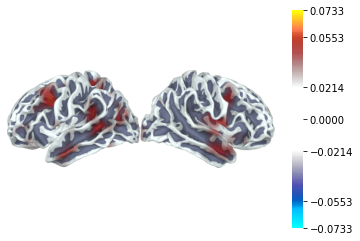

In [205]:
k = 5
source_map = mne.minimum_norm.apply_inverse(mne.EvokedArray(pass_through(proj.v_[:, k] @  proj.cov_)[:, None], info), inv, 0.15, verbose=False)
# or
# source_map = mne.beamformer.apply_lcmv(mne.EvokedArray(pass_through(proj.v_[:, k] @  proj.cov_)[:, None], info), lcmv)
# source_map.data = np.abs(source_map.data)

source_map = morph.apply(source_map)

f = plt.figure()
ax = f.add_subplot(111)
color_lims = [np.quantile(np.abs(source_map.data[:]), pc) for pc in (0.5, 0.975)] + [np.abs(source_map.data).max()]
clim = {'kind':'value', 'pos_lims': color_lims}
brain = source_map.plot(hemi='split', subjects_dir=datadir, background='w', cortex='bone', surface='white',
                           time_viewer=False, colormap=my_map, colorbar=False, initial_time=0.35, clim=clim, size=(1400, 400))
get_source_image_in_ax(brain, ax=[ax], clim=clim, cmap=my_map, times=None)

## TRF on band-specific power and phase

In [ ]:
data_path = 'Data/TRF_All_kinds/'
strf_files = glob.glob(data_path + '*strf*') #
itc_files = glob.glob(data_path + '*ITC*')  # both delta and theta
power_files = glob.glob(data_path + '*power*')
bads = ['MLT41', 'MRO52']
info = read_info(os.path.join(DATA_PATH, 'processed', 'sub-026', 'meg', 'audioBook-filtered-ICAed-raw.fif'))
info = pick_info(info, pick_types(info, meg=True, ref_meg=False, exclude=bads))

In [45]:
trf_itc = {}
for f in ['delta', 'theta']:
    trf_itc[f] = reduce(lambda x,y: x+y, [TRFEstimator.load(i) for i in itc_files if f in i])
trf_power = {}
for f in ['beta', 'gamma']:
    trf_power[f] = reduce(lambda x,y: x+y, [TRFEstimator.load(i) for i in power_files if f in i])

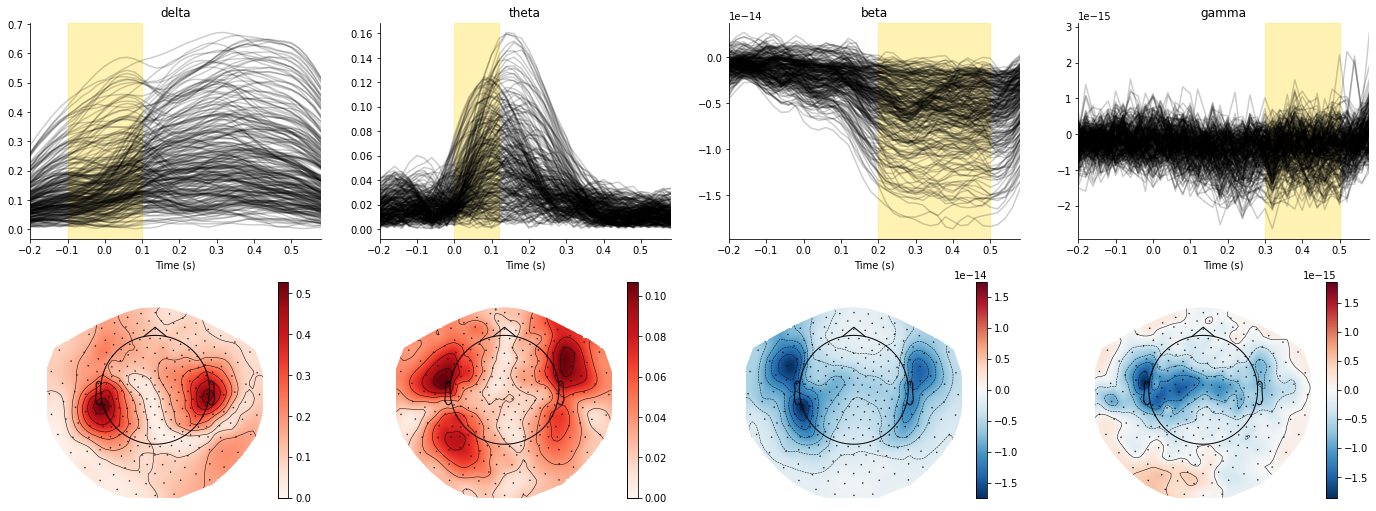

In [102]:
# TRF plots
time_to_samples = lambda t: np.argmin(abs(trf_itc['delta'].times - t))
time_spans = {'delta': (-0.1, 0.1), 'theta':(0.0, 0.12),
              'beta': (0.2, 0.5), 'gamma': (0.3, 0.5)}

with plt.rc_context({'axes.xmargin':0}):
    f, ax = plt.subplots(2, 4, figsize=(6*4, 8))
ax_bottom = ax[1,:]
ax = ax[0,:]

for k, (band, t) in enumerate(chain.from_iterable([tt.items() for tt in [trf_itc, trf_power]])):
    t1, t2 = time_spans[band]
    if band in ['delta', 'theta']:
        t = t.apply_func(np.abs);
    # TRFs
    t.plot(ax=ax[k])
    ax[k].axvspan(t1, t2, color='gold', alpha=0.3, zorder=0)
    ax[k].set_title(band)
    for axx in ax:    
        lines = axx.get_lines()
        for l in lines:
            l.set_color('k')
            l.set_alpha(0.2)
        axx.set_xlabel("Time (s)")
    
    # Topomaps
    s1, s2 = tuple(map(time_to_samples, (t1, t2)))
    topomap(t.coef_[s1:s2].mean(0).squeeze(), info, ax=ax_bottom[k])

sns.despine()

##  Score per band (ITC and Power from TRFs)

What happens if I take the data from `/project/3027007.01/analysis/Hugo/Data/ReconstructionScores` (where I have also several bands!!) instead of the ones here in `./Data/sub***scores.csv` (which are only for ITPC and power btw)...???

In [9]:
from itertools import product

In [10]:
datafiles_v2 = lambda fband, feats: glob.glob(f'/project/3027007.01/analysis/Hugo/Data/ReconstructionScores/{fband}/*_sensor_score_{feat_names[feats]}.npy')

In [10]:
feat_names = {'w': 'wordonsets', 'w_e_s': 'wordonsets_surprisal_entropy', 'w_d_c':'wordonsets_depth_close', 'w_e_s_d_c': 'wordonsets_surprisal_entropy_depth_close'}

all_dfs_v2 = []
for band, feats in product(['broad', 'delta', 'theta', 'alpha', 'beta', 'gamma'], list(feat_names.keys())):
    files = datafiles_v2(band, feats)
    data = []
    for f in sorted(files):
        subj = f[f.find('sub'):f.find('sub')+7]
        d = np.load(f)
        if np.iscomplexobj(d): d = np.abs(d)
        data.append({'subj':subj, 'feats':feats, 'fband': band, 'score': d.mean(), 'score_rel': np.nan, 'score_pct': np.nan})
    df = pd.DataFrame(data)
    all_dfs_v2.append(df)

df_v2 = pd.concat(all_dfs_v2, ignore_index=True)
for band, feats in product(['broad', 'delta', 'theta', 'alpha', 'beta', 'gamma'], list(feat_names.keys())):
    try:
        df_v2.loc[(df_v2.feats==feats) & (df_v2.fband==band), 'score_rel'] = df_v2.loc[(df_v2.feats==feats) & (df_v2.fband==band)].score.values - df_v2.loc[(df_v2.feats=='w') & (df_v2.fband==band)].score.values
    except:
        continue
    # for s in np.unique(df_v2.subj):
    #     if (s not in df_v2.loc[(df_v2.feats==feats) & (df_v2.fband == band), 'subj']) or (s not in df_v2.loc[(df_v2.feats=='w') & (df_v2.fband == band), 'subj']): continue
    #     df_v2.loc[(df_v2.subj==s) & (df_v2.feats==feats) & (df_v2.fband == band), 'score_rel'] = df_v2.loc[(df_v2.subj==s) & (df_v2.feats==feats) & (df_v2.fband == band), 'score'].values - df_v2.loc[(df_v2.subj==s) & (df_v2.feats=='w') & (df_v2.fband == band), 'score'].values
    #     df_v2.loc[(df_v2.subj==s) & (df_v2.feats==feats) & (df_v2.fband == band), 'score_pct'] = (df_v2.loc[(df_v2.subj==s) & (df_v2.feats==feats) & (df_v2.fband == band), 'score'] - df_v2.loc[(df_v2.subj==s) & (df_v2.feats=='w') & (df_v2.fband == band), 'score'])/df_v2.loc[(df_v2.subj==s) & (df_v2.feats=='w') & (df_v2.fband == band), 'score'] * 100.0

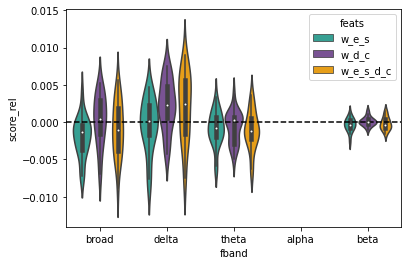

In [44]:
sns.violinplot(data=df_v2.loc[(df_v2.feats!='w') & (df_v2.subj !='sub-017') & (df_v2.subj != 'sub-002')],
                x='fband', y='score_rel', hue='feats', palette=palette, ci=97.5, saturation=0.8)
plt.axhline(0.0, color='k', ls='--')

In [11]:
#datafiles = lambda fband, itc: glob.glob(f'Data/sub-*_{fband}_{itc}_story-score.csv')
datafiles = lambda fband, itc: glob.glob(f'Data/sub-*_{fband}_{itc}_score.csv')

all_dfs = []
for band, dtype in zip(['delta', 'theta', 'alpha', 'beta', 'gamma'], ['itc']*2 + ['power']*3):
    files = datafiles(band, dtype)
    data = []
    for d in files:
        data.append(pd.read_csv(d))
    df = pd.concat(data, ignore_index=True)
    df = df.drop(columns='Unnamed: 0')
    if dtype=='itc':
         df[['score', 'score_rel', 'score_null']] = df[['score', 'score_rel', 'score_null']].applymap(np.complex_).applymap(np.abs)
 #       df[['score', 'score_null']] = df[['score', 'score_null']].applymap(np.complex_).applymap(np.abs)
    df['fband'] = band
    all_dfs.append(df.copy())
df = pd.concat(all_dfs)
df['score_pct'] = df.score_rel/np.maximum(df.score, df.score_null) * 100
#df['score_pct'] = (df.score - df.score_null)/df.score_null * 100

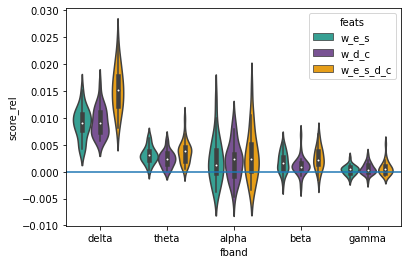

In [146]:
sns.violinplot(data=df.loc[(df.feats!='w')],
                x='fband', y='score_rel', hue='feats', palette=palette, ci=97.5, saturation=0.8)
plt.axhline(0)

In [12]:
fband = 'theta'
select_rows = (df.fband==fband) & (df.subj != 'sub-017') & (df.subj != 'sub-002')
print('Stats>Syntax: ', ttest_1samp(df.loc[(df.feats=='w_e_s') & select_rows, 'score_rel'].values - \
            df.loc[(df.feats=='w_d_c') & select_rows, 'score_rel'].values,
            0,
            alternative='greater'))
print('Full>Syntax: ',ttest_1samp(df.loc[(df.feats=='w_e_s_d_c') & select_rows, 'score_rel'].values - \
            df.loc[(df.feats=='w_d_c') & select_rows, 'score_rel'].values,
            0,
            alternative='greater'))
print('Stats>0: ', ttest_1samp(df.loc[(df.feats=='w_e_s') & select_rows, 'score_rel'].values,
            0,
            alternative='greater'))
print('Synt>0: ',ttest_1samp(df.loc[(df.feats=='w_d_c') & select_rows, 'score_rel'].values,
            0,
            alternative='greater'))

Stats>Syntax:  TtestResult(statistic=1.7986820881452434, pvalue=0.04260341257739758, df=23)
Full>Syntax:  TtestResult(statistic=4.116696823980296, pvalue=0.00021043922811577384, df=23)
Stats>0:  TtestResult(statistic=10.167722262693724, pvalue=2.7901337699889973e-10, df=23)
Synt>0:  TtestResult(statistic=8.186049576811776, pvalue=1.4423271338460782e-08, df=23)


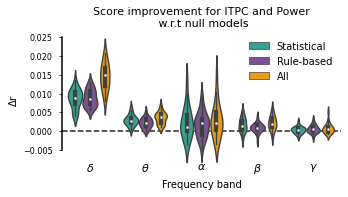

In [38]:
full_width = True
with plt.style.context([{'pdf.fonttype':42}, 'seaborn-paper', paper_fontsizes]):
    # ax = sns.barplot(data=df.loc[(df.feats!='w') & (df.subj !='sub-017')],
    #             x='fband', y='score_rel', hue='feats', palette=palette, ci=97.5, saturation=0.8)
    if not full_width:
        f, ax = plt.subplots(1, 1, figsize=(7.5*(2/3), 7.5/3))
    else:
        f, ax = plt.subplots(1, 1, figsize=(7.5, 7.5/3))
    sns.violinplot(data=df.loc[(df.feats!='w') & (df.subj !='sub-017') & (df.subj != 'sub-002')],
                x='fband', y='score_rel', hue='feats', palette=palette, ci=97.5, saturation=0.8, ax=ax)
    ax.axhline(0.0, color=[0.15]*3, lw=1.5, ls='--', zorder=-1)
    plt.xlabel('Frequency band')
    plt.ylabel(r'$\Delta$r')
    plt.title('Score improvement for ITPC and Power\n w.r.t null models')
    
    loc, labels = plt.xticks()
    labels = ['$\delta$', '$\\theta$', '$\\alpha$', '$\\beta$', '$\gamma$']
    plt.xticks(loc, labels, rotation=0);
    ax.legend_.set(frame_on=False, title='')
    ax.legend_.texts[0].set_text('Statistical')
    ax.legend_.texts[1].set_text('Rule-based')
    ax.legend_.texts[2].set_text('All')
    ax.axes.spines['bottom'].set_visible(False)
    ax.axes.tick_params('x', bottom=False, labelsize=11, pad=-10)
    ax.axes.spines['left'].set_linewidth(1.5)
    sns.despine(bottom=True, trim=True)
    if not full_width:
        plt.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure4_PanelB_size2third.pdf', bbox_inches='tight', dpi=300)
    else:
        plt.savefig('../../Manuscripts/SyntaxPaper/Figures/Figure4_PanelB_fullWidth.pdf', bbox_inches='tight', dpi=300)

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [42]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("score_rel ~ feats * fband", df.loc[(df.feats!='w') & (df.subj !='sub-017') & (df.subj != 'sub-002')],
                 groups=df.loc[(df.feats!='w') & (df.subj !='sub-017') & (df.subj != 'sub-002'), "subj"], re_formula='1 + fband')
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        score_rel
No. Observations:          360            Method:                    REML     
No. Groups:                24             Scale:                     0.0000   
Min. group size:           15             Log-Likelihood:            1649.2603
Max. group size:           15             Converged:                 Yes      
Mean group size:           15.0                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.002    0.001  2.408 0.016  0.000  0.003
feats[T.w_e_s]                       0.001    0.000  1.146 0.252 -0.000  0.001
feats[T.w_e_s_d_c]                   0.001    0.000  2.525 0.012  0.000  